---
# Bayesian approach to traffic incident prediction

Adam Filapek, Łukasz Faruga

---

#### [GitHub repo link](https://github.com/lf-netizen/traffic-incident-prediction)

In [1]:
import os
import sys
import pandas as pd
from pathlib import Path

from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import pandas as pd

PROJECT_ROOT = Path(os.getenv("PROJECT_ROOT"))
SCRIPTS_DIR = PROJECT_ROOT / "scripts"
DATA_DIR = PROJECT_ROOT / "data"
IMG_DIR = PROJECT_ROOT / "img"
STAN_PATH = PROJECT_ROOT / "scripts/stan"
DATA_PATH = f"{PROJECT_ROOT}/data/analysis"

sys.path.append(str(PROJECT_ROOT))


from utils.notebook import run_notebook
from utils.display import display_df, display_image

## 1. Introduction
Road traffic accidents constitute a significant global public health challenge. According to the World Health Organization (WHO), an estimated 1.19 million road traffic fatalities occurred in 2021, with a disproportionate burden on low- and middle-income countries [1]. Projections indicate that by 2030, road traffic injuries will ascend to become the seventh leading cause of death worldwide [6].
The economic impact of these incidents is equally concerning. Estimates suggest that road injuries will impose a US$1.8 trillion burden on the global economy between 2015 and 2030 (in constant 2010 US dollars) [7].

Various approaches to model this phenomena have been proposed.
Popular methods include neural networks, such as Multilayer Perceptrons (MLPs) [5] or Convolutional Neural Networks (CNNs) [2].
Alongside predictive performance, model interpretability remains important for deriving actionable insights. Algoritms using i.e. tree-based methods like random forests or ensemble methods such as gradient boosting or XGBoost allow for identifying important features with the explainable ML (XML) techniques [3].

These predictive models incorporate a wide range of variables, including but not limited to traffic flow patterns, meteorological and lightning conditions, driver demographics and experience, vehicle classifications, geographical locations, and road surface conditions [2, 3, 4].

### Our project
This project focuses on developing a Bayesian model to predict traffic incident counts based on weather data. Our objective is to generate monthly predictions at the voivodeship level in Poland.

The insights derived from such model have potential applications across various sectors. Government authorities could leverage these predictions to inform long-term infrastructure decisions, such as road improvements or hospital placements. Additionally, the model could guide the strategic deployment of emergency responders during periods of heightened incident risk.
Public institutions stand to benefit as well, using the data to tailor their awareness campaigns and more effectively alert drivers to potential dangers. In the private sector, insurance companies might incorporate these predictions into their risk assessment processes and pricing models, allowing for more accurate policy adjustments.

### DAG & Cofoundings

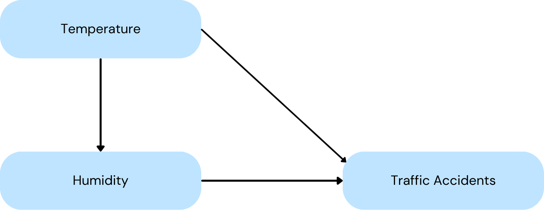

In [2]:
display_image(IMG_DIR / "dag.png", scale=0.4)

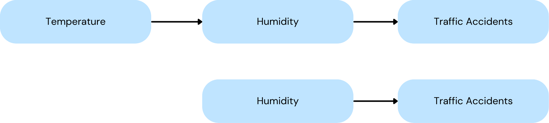

In [3]:
display_image(IMG_DIR / "cofoundings.png", scale=0.3)

Traffic accidents are influenced by temperature and humidity. Humidity is influenced by temperature.

## 2. Data aquisition & preprocessing

The datasets span from Jan 2018 to Dec 2022.

### Incidents data
For the project we were particularly interested in the total number of traffic incidents in a given voivodeship per month.

The data comes from [SEWIK](https://sewik.pl/) _(System Ewidencji Wypadków i Kolizji)_ - a website which serves as a search engine for traffic incident data in Poland.
Unfortunately, this service does not publicly offer data in the form of .csv or .sql files, therefore we wrote a custom script for scraping the data using Selenium WebDriver.
The script interacts with the webpage by filling and submitting the form, downloads the resulting page contents, extracts tabular data from raw HTML and saves it in .csv files.

The preprocessing step involved merging tables from different files into a single one.

In [4]:
run_notebook(SCRIPTS_DIR / "processing/incidents.ipynb")
display_df(DATA_DIR / "intermediate/incidents.csv")

,year,month,voivodeship,incidents
0,2018,1,dolnośląskie,3382
1,2018,2,dolnośląskie,3095
2,2018,3,dolnośląskie,3750
3,2018,4,dolnośląskie,3478
4,2018,5,dolnośląskie,3680


### Weather data

The weather data has been collected from [IMGW](https://danepubliczne.imgw.pl/pl/datastore) _(Instytut Meteorologii i Gospodarki Wodnej)_.

To represent the weather conditions for a voivodeship we manunally choose a representative station for each one of them. It was crucial to choose a station with a complete set of datapoints over the entire timespan of out interest.


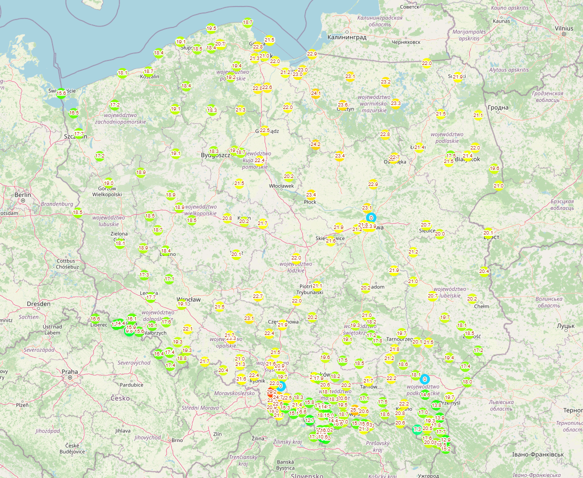

In [5]:
display_image(IMG_DIR / "map_stations.png", scale=0.5)

In [6]:
display_df(DATA_DIR / "input/voivodeships/weather_stations.csv")

,station_id,voivodeship,location
0,353150210,zachodniopomorskie,Resno-Smólsko
1,254170140,pomorskie,Kościerzyna
2,353200272,warmińsko-mazurskie,Olsztyn
3,351150400,lubuskie,Zielona Góra
4,352160330,wielkopolskie,Poznań


Among parameters collected by the stations we choose temperature and humidity.


Preprocessing consisted of filtering out the data for stations mentioned. Then average values were calculated for a given month and station.

In [7]:
run_notebook(SCRIPTS_DIR / "processing/weather.ipynb")
display_df(DATA_DIR / "intermediate/weather_measurements.csv")

,year,month,voivodeship,temperature,humidity
0,2018,1,małopolskie,-1.149677,89.855484
1,2018,2,małopolskie,-2.167143,92.866429
2,2018,3,małopolskie,-0.725484,87.644194
3,2018,4,małopolskie,10.383333,72.174667
4,2018,5,małopolskie,17.081613,77.249677


### Data merging 

The data preprocessed above was merged together with respect to voivodeship, year and month.

In [8]:
run_notebook(SCRIPTS_DIR / "processing/merge.ipynb")
display_df(DATA_DIR / "intermediate/data_all.csv")

,year,month,voivodeship,temperature,humidity,incidents
0,2018,1,małopolskie,-1.149677,89.855484,2879
1,2018,2,małopolskie,-2.167143,92.866429,2658
2,2018,3,małopolskie,-0.725484,87.644194,2741
3,2018,4,małopolskie,10.383333,72.174667,2848
4,2018,5,małopolskie,17.081613,77.249677,2909


### The preparation of model input samples

A single batch of data serving as a model input is data for a given voivodeship in a given year.

We choose our input samples to be:
* mazowieckie in 2021
* mazowieckie in 2022
* opolskie in 2020

In [9]:
run_notebook(SCRIPTS_DIR / "processing/sample.ipynb")
display_df(DATA_DIR / "analysis/2021_mazowieckie.csv")

,year,month,voivodeship,temperature,humidity,incidents
0,2021,1,mazowieckie,-1.480645,89.451613,4830
1,2021,2,mazowieckie,-4.246429,87.321429,4922
2,2021,3,mazowieckie,1.145161,86.225806,4717
3,2021,4,mazowieckie,6.150000,78.066667,4896
4,2021,5,mazowieckie,13.832258,77.161290,5902


In [10]:
file_names = ['2021_mazowieckie.csv', 
              '2020_opolskie.csv',
              '2022_mazowieckie.csv']

data = []
for file_name in file_names:
    with open(f"{DATA_PATH}/{file_name}", 'r') as file:
        data.append(pd.read_csv(file))

## 3. Models

### Description
After analysis we decided to use two Poisson models because it is known for working well with data where certain number of events occur in a fixed interval - in this case it is number of accidents per month.

The first model was based solely on humidity
$$ y \sim \text{Poisson}(\lambda) $$
$$ \lambda = a \cdot h $$
$$ a \sim \text{Normal}(\mu_{a}, \sigma_{a})$$

while the second one addded temperature and a constant.
$$ y \sim \text{Poisson}(\lambda) $$
$$ \lambda = a \cdot h + b \cdot t + c$$
$$ a \sim \text{Normal}(\mu_{a}, \sigma_{a})$$
$$ b \sim \text{Normal}(\mu_{b}, \sigma_{b})$$
$$ c \sim \text{Normal}(\mu_{c}, \sigma_{c})$$

## Priors



First, we determined the upper bound of accidents. Historically, the highest number of accidents per month per voivodeship is approximately 7,000. To ensure we were not biased by searching for patterns in the data, we set the upper bound to be at least twice this highest recorded value, resulting in an upper bound of 15,000.


### Model 1 - prior predictive checks

We used a known equation for the upper bound based on $\lambda = a \cdot h_{\text{avg}}$, where $h_{\text{avg}}$ is the mean value of humidity in the dataset:

$$ a \cdot h_{\text{avg}} + 3 \sqrt{a \cdot h_{\text{avg}}} \approx 15{,}000 \implies a \cdot h_{\text{avg}} = 14{,}637 $$

Based on that we calculated prior $\sigma_{a}$ with the help of the tuning function.

In [11]:
with open(f"{DATA_DIR}/intermediate/data_all.csv") as f:
    d = pd.read_csv(f)

In [12]:
tuning = CmdStanModel(stan_file=f'{STAN_PATH}/prior1_tune.stan')

In [13]:
# a upper bound calculation
mean_humidity = np.mean(d['humidity'])
root_of_lambda = np.polynomial.polynomial.polyroots([-15000., 3., 1.])
root_of_a = np.polynomial.polynomial.polyroots([-15000./mean_humidity, 3./np.sqrt(mean_humidity), 1.])
a_ub = root_of_a[root_of_lambda>0]**2
print(f'a upper bound: {a_ub[0]:.2f}')

a upper bound: 174.21


In [14]:
# sigma_a calculation
data_tune = dict(y_guess = np.array([np.log(100)]),
                 theta = np.array(a_ub))
tuned = tuning.sample(data=data_tune,
                      seed=1052020,
                      fixed_param=True,
                      iter_sampling=1, 
                      iter_warmup=1,
                      #   show_console=True,
                      chains=1)
sigma = tuned.stan_variable('sigma')[0]
print(f'Computed suggested standard deviation for parameter a: {sigma:.0f}')

09:46:58 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

09:46:58 - cmdstanpy - INFO - CmdStan done processing.



Computed suggested standard deviation for parameter a: 68


The tuning returned the suggested value for $\sigma_{a}$, therefore

$$a \sim \text{Normal}(0, 68) $$

After that we moved to prior predictive checks.

In [15]:
with open(f'{STAN_PATH}/prior1.stan', 'r') as file:
    print(file.read())

data {
    int<lower=0> N;
    array[N] real<lower=0, upper=100> humidity;
}

generated quantities {
    real<lower=0> a = abs(normal_rng(0, 68));

    array[N] int<lower=0> accidents_pred;
    for (i in 1:N) {
        accidents_pred[i] = poisson_rng(a * humidity[i]);
    }
}


In [16]:
model1_ppc = CmdStanModel(stan_file=f'{STAN_PATH}/prior1.stan')

In [17]:
def data_sim(df):
    return {'N': len(df), 
            'temperature': df['temperature'],
            'humidity': df['humidity']}

R = 1000
sim = model1_ppc.sample(
    data=data_sim(data[1]),
    iter_sampling=R,
    iter_warmup=1,
    chains=1,
    fixed_param=True,
    seed=42,
    refresh=R
)

accidents_pred_prior = sim.stan_variable("accidents_pred")
accidents_pred_prior_means = np.mean(accidents_pred_prior, axis=0)
a_pred = sim.stan_variable("a")

09:46:59 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

09:46:59 - cmdstanpy - INFO - CmdStan done processing.


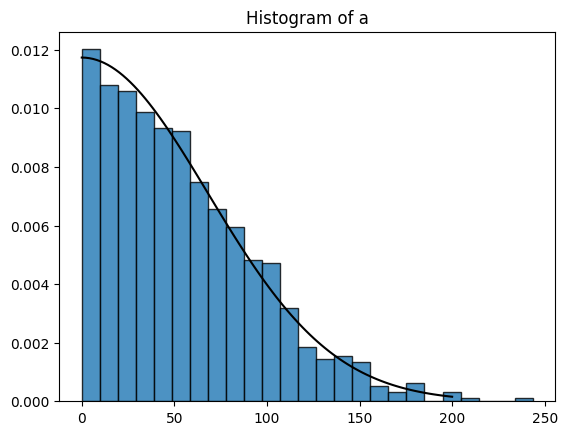

In [18]:
x = np.linspace(0, 200, 100)
y = 2 * stats.norm.pdf(x=x, loc=0, scale=68)
plt.hist(a_pred, bins=25, density=True, alpha=0.8, edgecolor='black')
plt.plot(x, y, color='k')
plt.xlabel('')
plt.ylabel('')
plt.title(r'Histogram of a')
plt.show()

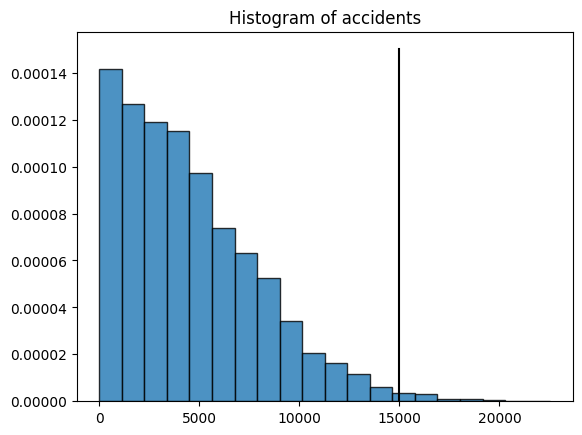

In [19]:
plt.hist(accidents_pred_prior.flatten(), bins=20, density=True, alpha=0.8, edgecolor='black')
plt.plot([15000, 15000], [0, 0.00015], color='k')
plt.xlabel('')
plt.ylabel('')
plt.title(r'Histogram of accidents')
plt.show()

Our assumed upper bound for accident count is 15000. Based on the above diagram we see that the data is within reach.


### Model 2 - prior predictive checks

For parameter $a$, we used the distribution in the previous example.
We know the expected values of temperature are approximately one order of magniture larger than those values for humidity. Therefore we 10x the $\sigma_b$

Sice we know the number of accidents per month is approximately 4000, we choose to represent a constant value as half of that with the whole range from zero to approx. covered within two $\sigma_c$

$$ a \sim \text{Normal}(0, 68)$$
$$ b \sim \text{Normal}(0, 680)$$
$$ c \sim \text{Normal}(2000, 1000)$$

In [20]:
with open(f'{STAN_PATH}/prior2.stan', 'r') as file:
    print(file.read())

data {
    int<lower=0> N;
    array[N] real<lower=0, upper=100> humidity;
    array[N] real temperature;
}

generated quantities {
    real a = normal_rng(0, 68);
    real b = normal_rng(0, 680);
    real c = normal_rng(2000, 1000);

    array[N] int<lower=0> accidents_pred;
    for (i in 1:N) {
        accidents_pred[i] = poisson_rng(abs(a * humidity[i] + b * temperature[i] + c));
    }
}


In [21]:
model2_ppc = CmdStanModel(stan_file=f'{STAN_PATH}/prior2.stan')

In [22]:
def data_sim(df):
    return {'N': len(df), 
            'humidity': df['humidity'],
            'temperature': df['temperature'],
            }

R = 1000
sim = model2_ppc.sample(
    data=data_sim(data[1]),
    iter_sampling=R,
    iter_warmup=1,
    chains=1,
    fixed_param=True,
    seed=42,
    refresh=R
)

accidents_pred_prior = sim.stan_variable("accidents_pred")
accidents_pred_prior_means = np.mean(accidents_pred_prior, axis=0)
a_pred = sim.stan_variable("a")
b_pred = sim.stan_variable("b")
c_pred = sim.stan_variable("c")

09:47:00 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

09:47:00 - cmdstanpy - INFO - CmdStan done processing.


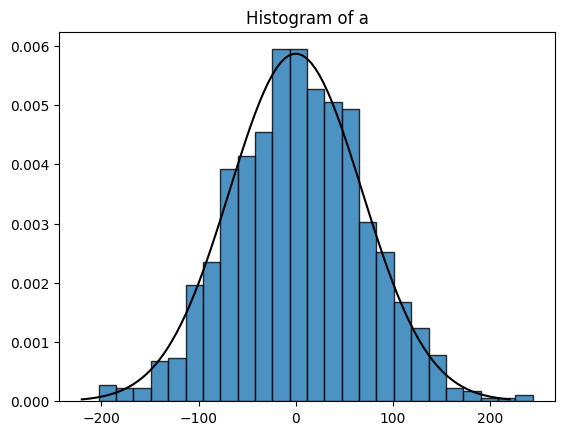

In [23]:
x = np.linspace(-220, 220, 100)
y = stats.norm.pdf(x=x, loc=0, scale=68)
plt.hist(a_pred, bins=25, density=True, alpha=0.8, edgecolor='black')
plt.plot(x, y, color='k')
plt.xlabel('')
plt.ylabel('')
plt.title(r'Histogram of a')
plt.show()

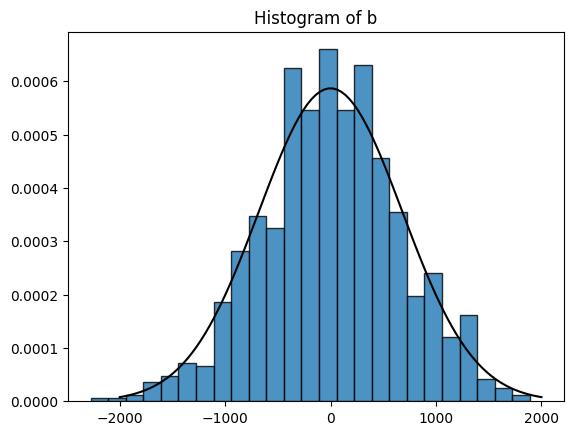

In [24]:
x = np.linspace(-2000, 2000, 100)
y = stats.norm.pdf(x=x, loc=0, scale=680)
plt.hist(b_pred, bins=25, density=True, alpha=0.8, edgecolor='black')
plt.plot(x, y, color='k')
plt.xlabel('')
plt.ylabel('')
plt.title(r'Histogram of b')
plt.show()

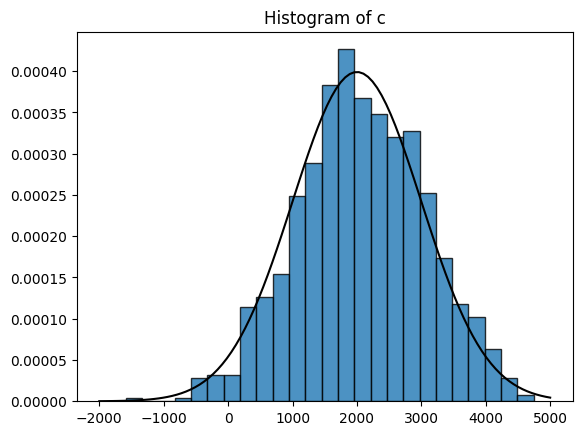

In [25]:
x = np.linspace(-2000, 5000, 100)
y = stats.norm.pdf(x=x, loc=2000, scale=1000)
plt.hist(c_pred, bins=25, density=True, alpha=0.8, edgecolor='black')
plt.plot(x, y, color='k')
plt.xlabel('')
plt.ylabel('')
plt.title(r'Histogram of c')
plt.show()

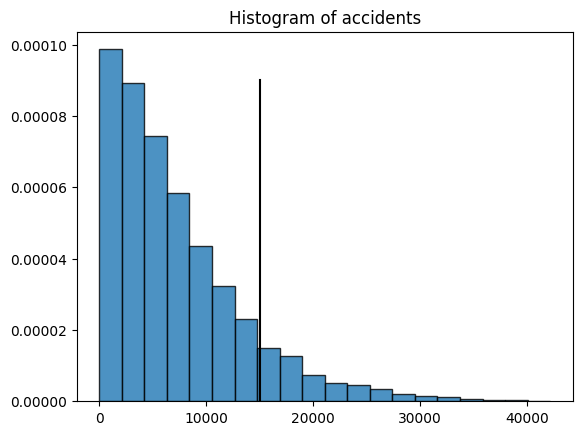

In [26]:
plt.hist(accidents_pred_prior.flatten(), bins=20, density=True, alpha=0.8, edgecolor='black')
plt.plot([15000, 15000], [0, 0.00009], color='k')
plt.xlabel('')
plt.ylabel('')
plt.title(r'Histogram of accidents')
plt.show()

Our assumed upper bound for accident count is 15000. Based on the above diagram we see the data is within reach.

## Posterior analysis (model 1)

In [27]:
with open(f'{STAN_PATH}/fit1.stan', 'r') as file:
    print(file.read())

data {
    int<lower=0> N;
    array[N] real<lower=0, upper=100> humidity;
    array[N] int<lower=0> accidents;
}

parameters {
    real<lower=0> a;
}

model {
    a ~ normal(0, 68);
    for (i in 1:N) {
        accidents[i] ~ poisson(a * humidity[i]);
    }
}

generated quantities {
    array[N] int accidents_pred;
    array[N] real log_lik;
    for (i in 1:N) {
        log_lik[i] = poisson_lpmf(accidents[i] | a * humidity[i]);
        accidents_pred[i] = poisson_rng(a * humidity[i]);
    }
}


In [28]:
model_1_fit = CmdStanModel(stan_file=f'{STAN_PATH}/fit1.stan')

In [29]:
def fit_model1(df): 
    data_sim = {
        'N': len(df), 
        'humidity': df['humidity'],
        'temperature': df['temperature'],
        'accidents': df['incidents']}

    fit = model_1_fit.sample(data=data_sim,
                            output_dir='samples', 
                            show_progress=False,
                            seed=28052020)

    # a_fit = fit.stan_variable('a')
    # b_fit = fit.stan_variable('b')
    # c_fit = fit.stan_variable('c')
    accidents_pred = fit.stan_variable('accidents_pred')

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.bar(list(df['month']), df['incidents'].values, alpha=0.5)
    ax1.bar(list(df['month']), np.mean(accidents_pred, axis=0), alpha=0.5)
    ax1.set_title(f"{df.year[0]} {df.voivodeship[0]}")
    # ax2.invert_yaxis()
    # ax2.set_yticks(np.arange(1, 21))
    # ax2.set_yticklabels([i+1 for i in range(20)])
    # ax2.scatter(list(d_new['driver_name']), d_new.race_position, color='r')
    plt.show()

    return fit

In [30]:
def data_sim(df):
    return {
    'N': len(df), 
    'temperature': df['temperature'],
    'humidity': df['humidity'],
    'accidents': df['incidents']}

sim = model_1_fit.sample(data=data_sim(data[0]),
                        output_dir='samples', 
                        show_progress=False,
                        seed=28052020)

accidents_pred_prior = sim.stan_variable("accidents_pred")
accidents_pred_prior_means = np.mean(accidents_pred_prior, axis=0)
a_pred = sim.stan_variable("a")

09:47:02 - cmdstanpy - INFO - CmdStan start processing


09:47:02 - cmdstanpy - INFO - Chain [1] start processing
09:47:02 - cmdstanpy - INFO - Chain [2] start processing
09:47:02 - cmdstanpy - INFO - Chain [3] start processing
09:47:02 - cmdstanpy - INFO - Chain [4] start processing
09:47:02 - cmdstanpy - INFO - Chain [4] done processing
09:47:02 - cmdstanpy - INFO - Chain [1] done processing
09:47:02 - cmdstanpy - INFO - Chain [2] done processing
09:47:02 - cmdstanpy - INFO - Chain [3] done processing


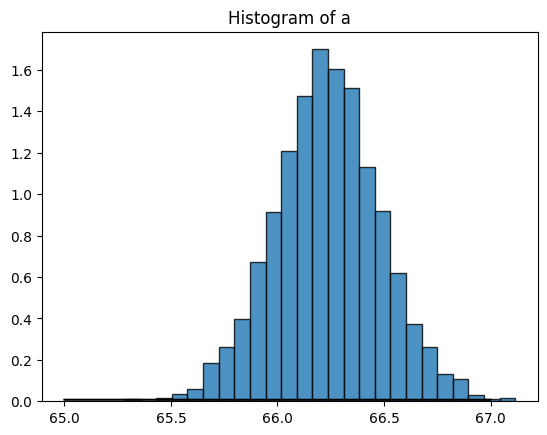

In [31]:
x = np.linspace(65, 67, 100)
y = 2 * stats.norm.pdf(x=x, loc=0, scale=68)
plt.hist(a_pred, bins=25, density=True, alpha=0.8, edgecolor='black')
plt.plot(x, y, color='k')
plt.xlabel('')
plt.ylabel('')
plt.title('Histogram of a')
plt.show()

09:47:02 - cmdstanpy - INFO - CmdStan start processing
09:47:02 - cmdstanpy - INFO - Chain [1] start processing
09:47:02 - cmdstanpy - INFO - Chain [2] start processing
09:47:02 - cmdstanpy - INFO - Chain [3] start processing
09:47:02 - cmdstanpy - INFO - Chain [4] start processing
09:47:02 - cmdstanpy - INFO - Chain [3] done processing
09:47:02 - cmdstanpy - INFO - Chain [2] done processing
09:47:02 - cmdstanpy - INFO - Chain [4] done processing
09:47:02 - cmdstanpy - INFO - Chain [1] done processing


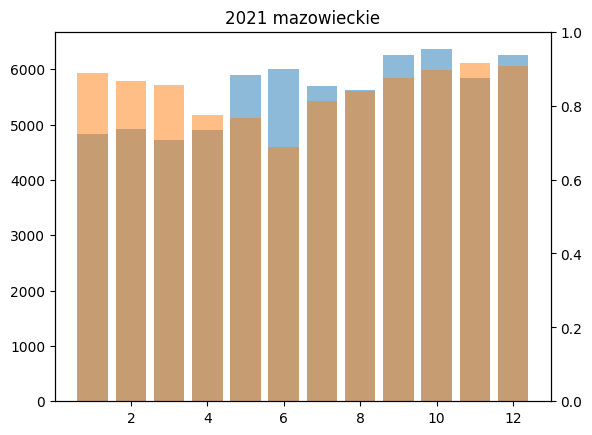

09:47:03 - cmdstanpy - INFO - CmdStan start processing
09:47:03 - cmdstanpy - INFO - Chain [1] start processing
09:47:03 - cmdstanpy - INFO - Chain [2] start processing
09:47:03 - cmdstanpy - INFO - Chain [3] start processing
09:47:03 - cmdstanpy - INFO - Chain [4] start processing
09:47:03 - cmdstanpy - INFO - Chain [4] done processing
09:47:03 - cmdstanpy - INFO - Chain [2] done processing
09:47:03 - cmdstanpy - INFO - Chain [3] done processing
09:47:03 - cmdstanpy - INFO - Chain [1] done processing


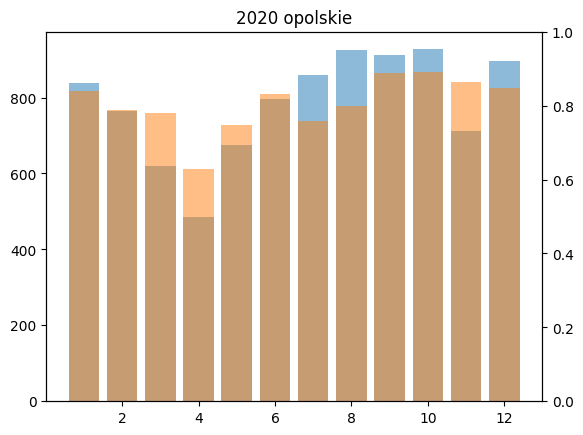

09:47:03 - cmdstanpy - INFO - CmdStan start processing
09:47:03 - cmdstanpy - INFO - Chain [1] start processing
09:47:03 - cmdstanpy - INFO - Chain [2] start processing
09:47:03 - cmdstanpy - INFO - Chain [3] start processing
09:47:03 - cmdstanpy - INFO - Chain [4] start processing
09:47:03 - cmdstanpy - INFO - Chain [2] done processing
09:47:03 - cmdstanpy - INFO - Chain [3] done processing
09:47:03 - cmdstanpy - INFO - Chain [1] done processing
09:47:03 - cmdstanpy - INFO - Chain [4] done processing


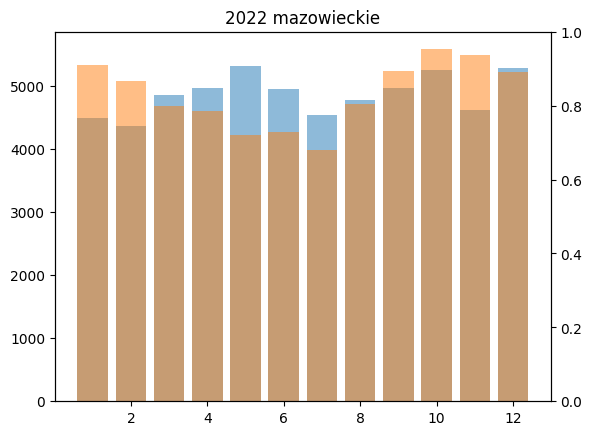

In [32]:
samples1_0 = fit_model1(data[0])
samples1_1 = fit_model1(data[1])
samples1_2 = fit_model1(data[2])

## Posterior analysis (model 2)

In [33]:
with open(f'{STAN_PATH}/fit2.stan', 'r') as file:
    print(file.read())

data {
    int<lower=0> N;
    array[N] real<lower=0, upper=100> humidity;
    array[N] real temperature;
    array[N] int<lower=0> accidents;
}

parameters {
    real a;
    real b;
    real c;
}

model {
    a ~ normal(0, 68);
    b ~ normal(0, 680);
    c ~ normal(2000, 1000);
    for (i in 1:N) {
        accidents[i] ~ poisson(abs(a * humidity[i] + b * temperature[i] + c));
    }
}

generated quantities {
    array[N] int accidents_pred;
    array[N] real log_lik;
    for (i in 1:N) {
        log_lik[i] = poisson_lpmf(accidents[i] | abs(a * humidity[i] + b * temperature[i] + c));
        accidents_pred[i] = poisson_rng(abs(a * humidity[i] + b * temperature[i] + c));
    }
}


In [34]:
model_2_fit = CmdStanModel(stan_file=f'{STAN_PATH}/fit2.stan')

In [35]:
def fit_model2(df): 
    data_sim = {
        'N': len(df), 
        'humidity': df['humidity'],
        'temperature': df['temperature'],
        'accidents': df['incidents']}

    fit = model_2_fit.sample(data=data_sim,
                            output_dir='samples', 
                            show_progress=False,
                            seed=28052020)

    a_fit = fit.stan_variable('a')
    accidents_pred = fit.stan_variable('accidents_pred')

    fig, ax1 = plt.subplots()

    ax1.bar(list(df['month']), df['incidents'].values, alpha=0.5)
    ax1.bar(list(df['month']), np.mean(accidents_pred, axis=0), alpha=0.5)
    ax1.set_title(f"{df.year[0]} {df.voivodeship[0]}")
    ax1.legend(['Observed', 'Predicted'], loc="lower right")
    plt.show()
    return fit

In [36]:
def data_sim(df):
    return {
    'N': len(df), 
    'temperature': df['temperature'],
    'humidity': df['humidity'],
    'accidents': df['incidents']}

sim = model_2_fit.sample(data=data_sim(data[0]),
                        output_dir='samples', 
                        show_progress=False,
                        seed=28052020)

accidents_pred_prior = sim.stan_variable("accidents_pred")
accidents_pred_prior_means = np.mean(accidents_pred_prior, axis=0)
a_pred = sim.stan_variable("a")
b_pred = sim.stan_variable("b")
c_pred= sim.stan_variable("c")

09:47:04 - cmdstanpy - INFO - CmdStan start processing
09:47:04 - cmdstanpy - INFO - Chain [1] start processing
09:47:04 - cmdstanpy - INFO - Chain [2] start processing
09:47:04 - cmdstanpy - INFO - Chain [3] start processing
09:47:04 - cmdstanpy - INFO - Chain [4] start processing
09:47:04 - cmdstanpy - INFO - Chain [4] done processing
09:47:04 - cmdstanpy - INFO - Chain [1] done processing
09:47:04 - cmdstanpy - INFO - Chain [3] done processing
09:47:04 - cmdstanpy - INFO - Chain [2] done processing


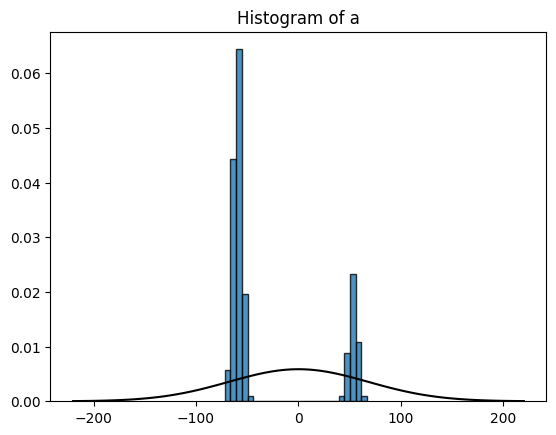

In [37]:
x = np.linspace(-220, 220, 100)
y = stats.norm.pdf(x=x, loc=0, scale=68)
plt.hist(a_pred, bins=25, density=True, alpha=0.8, edgecolor='black')
plt.plot(x, y, color='k')
plt.xlabel('')
plt.ylabel('')
plt.title(r'Histogram of a')
plt.show()

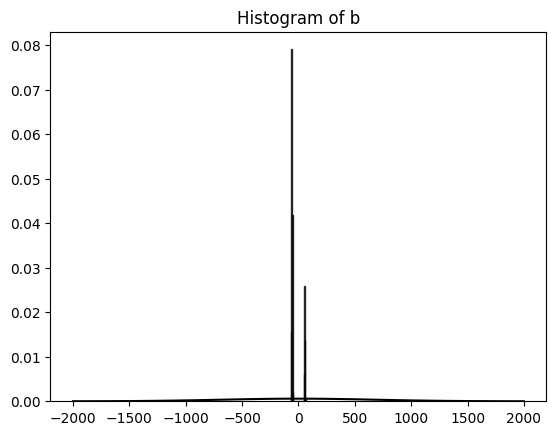

In [38]:
x = np.linspace(-2000, 2000, 100)
y = stats.norm.pdf(x=x, loc=0, scale=680)
plt.hist(b_pred, bins=25, density=True, alpha=0.8, edgecolor='black')
plt.plot(x, y, color='k')
plt.xlabel('')
plt.ylabel('')
plt.title(r'Histogram of b')
plt.show()

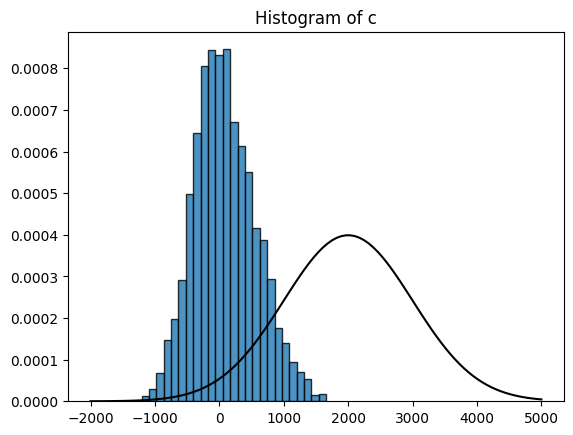

In [39]:
x = np.linspace(-2000, 5000, 100)
y = stats.norm.pdf(x=x, loc=2000, scale=1000)
plt.hist(c_pred, bins=25, density=True, alpha=0.8, edgecolor='black')
plt.plot(x, y, color='k')
plt.xlabel('')
plt.ylabel('')
plt.title(r'Histogram of c')
plt.show()

09:47:06 - cmdstanpy - INFO - CmdStan start processing
09:47:06 - cmdstanpy - INFO - Chain [1] start processing
09:47:06 - cmdstanpy - INFO - Chain [2] start processing
09:47:06 - cmdstanpy - INFO - Chain [3] start processing
09:47:06 - cmdstanpy - INFO - Chain [4] start processing
09:47:06 - cmdstanpy - INFO - Chain [4] done processing
09:47:06 - cmdstanpy - INFO - Chain [1] done processing
09:47:06 - cmdstanpy - INFO - Chain [3] done processing
09:47:06 - cmdstanpy - INFO - Chain [2] done processing


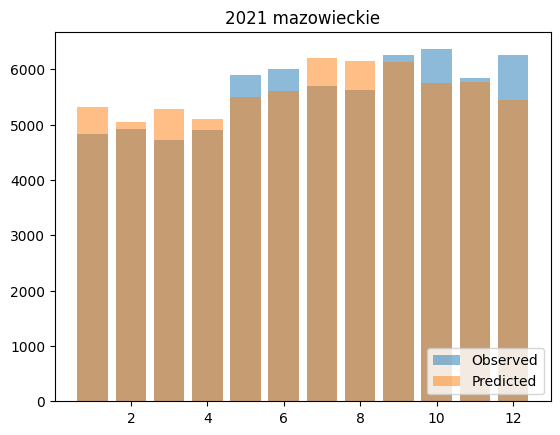

09:47:06 - cmdstanpy - INFO - CmdStan start processing
09:47:06 - cmdstanpy - INFO - Chain [1] start processing
09:47:06 - cmdstanpy - INFO - Chain [2] start processing
09:47:06 - cmdstanpy - INFO - Chain [3] start processing
09:47:06 - cmdstanpy - INFO - Chain [4] start processing
09:47:07 - cmdstanpy - INFO - Chain [4] done processing
09:47:07 - cmdstanpy - INFO - Chain [1] done processing
09:47:07 - cmdstanpy - INFO - Chain [3] done processing
09:47:07 - cmdstanpy - INFO - Chain [2] done processing


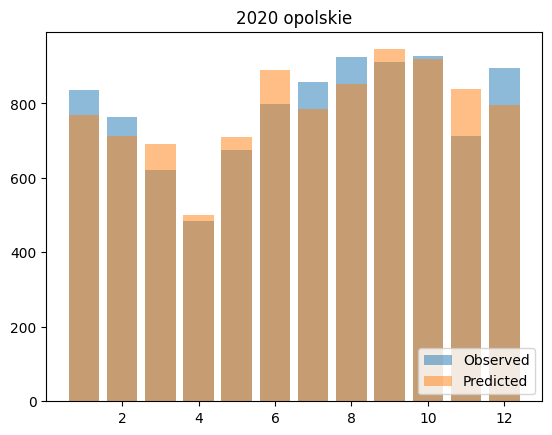

09:47:07 - cmdstanpy - INFO - CmdStan start processing
09:47:07 - cmdstanpy - INFO - Chain [1] start processing
09:47:07 - cmdstanpy - INFO - Chain [2] start processing
09:47:07 - cmdstanpy - INFO - Chain [3] start processing
09:47:07 - cmdstanpy - INFO - Chain [4] start processing
09:47:07 - cmdstanpy - INFO - Chain [1] done processing
09:47:07 - cmdstanpy - INFO - Chain [4] done processing
09:47:07 - cmdstanpy - INFO - Chain [3] done processing
09:47:07 - cmdstanpy - INFO - Chain [2] done processing


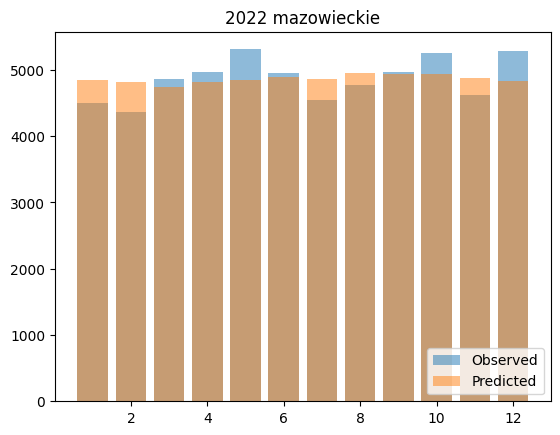

In [40]:
samples2_0 = fit_model2(data[0])
samples2_1 = fit_model2(data[1])
samples2_2 = fit_model2(data[2])

## Model comparison

In [41]:
comp_dict = {"model 1": samples1_0,
             "model 2": samples2_0}


### WAIC criterion

         rank   elpd_waic      p_waic   elpd_diff   weight          se  \
model 2     0 -354.062249  105.210292    0.000000  0.65881   68.157753   
model 1     1 -685.622957   86.933041  331.560709  0.34119  218.015864   

                dse  warning scale  
model 2    0.000000     True   log  
model 1  228.641941     True   log  


/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:1632: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


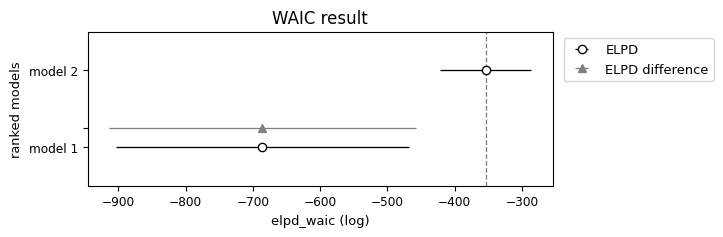

In [42]:
comp_waic = az.compare(comp_dict, ic="waic")
print(comp_waic)
az.plot_compare(comp_waic)
plt.title('WAIC result')
plt.show()

Based on this criteria we can see that model 2 is clearly better than model 1.

The warnings about the posterior variance of the log predictive densities exceeding the threshold have appeared.

### PSIS-LOO criterion

/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arviz/stats/stats.py:789: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


         rank    elpd_loo      p_loo   elpd_diff    weight          se  \
model 2     0 -345.597220  96.745264    0.000000  0.656957   65.170266   
model 1     1 -680.412927  81.723010  334.815707  0.343043  214.481521   

                dse  warning scale  
model 2    0.000000     True   log  
model 1  224.884098     True   log  


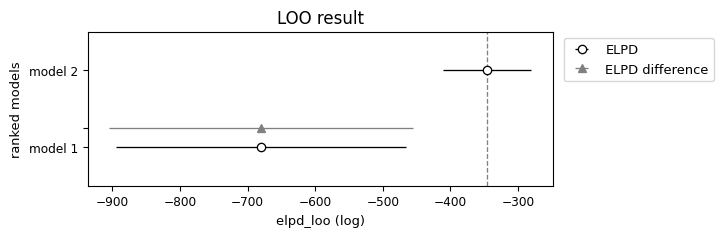

In [43]:
comp_loo = az.compare(comp_dict, ic="loo")
print(comp_loo)
az.plot_compare(comp_loo)
plt.title('LOO result')
plt.show()

Based on this criteria we can once again see that model 2 is clearly better than model 1.

The warnings regarding the robustness of models have appeared.

Based on both PSIS-LOO and WAIC criteria, the second model shows superior performance. This outcome is anticipated, as models with a greater number of parameters in general encapsulate more information, thereby enhancing their informativeness and accuracy.

However, it is important to note that the first model also performs well. 
We believe the difference of performance is minor and when accounting for the fact that the second model requires more data for execution, the difference in performance between the two models becomes less significant.


### References

[1] [WHO, Global status report on road safety 2023](https://iris.who.int/bitstream/handle/10665/375016/9789240086517-eng.pdf?sequence=1)

[2] [L. Wenqi, L. Dongyu and Y. Menghua, "A model of traffic accident prediction based on convolutional neural network," 2017 2nd IEEE International Conference on Intelligent Transportation Engineering (ICITE), Singapore, 2017, pp. 198-202, doi: 10.1109/ICITE.2017.8056908.](https://ieeexplore.ieee.org/abstract/document/8056908/authors#authors)

[3] [Shakil Ahmed, Md Akbar Hossain, Sayan Kumar Ray, Md Mafijul Islam Bhuiyan, Saifur Rahman Sabuj, A study on road accident prediction and contributing factors using explainable machine learning models: analysis and performance, Transportation Research Interdisciplinary Perspectives, Volume 19, 2023, 100814, ISSN 2590-1982](https://www.sciencedirect.com/science/article/pii/S2590198223000611?via%3Dihub)

[4] [Yassin, S.S., Pooja Road accident prediction and model interpretation using a hybrid K-means and random forest algorithm approach. SN Appl. Sci. 2, 1576 (2020).](https://link.springer.com/article/10.1007/s42452-020-3125-1)

[5] [Mayura Yeole, Rakesh Kumar Jain, Radhika Menon, "Prediction of Road Accident Using Artificial Neural Network," International Journal of Engineering Trends and Technology, vol. 70, no. 3, pp. 151-161, 2022.](https://www.pccoer.com/NAAC/CR-3/3.3.1/13.%202021-22civil13.pdf)

[6] [Ahmed, Sirwan & Mohammed, Mona & Abdulqadir, Salar & Abd Elkader, Rabab & El-Shall, Nahed & Chandran, Deepak & Rehman, Mohammad Ebad Ur & Dhama, Kuldeep. (2023). Road traffic accidental injuries and deaths: A neglected global health issue. Health Science Reports. 6. e1240. 10.1002/hsr2.1240.](https://www.researchgate.net/publication/370299859_Road_traffic_accidental_injuries_and_deaths_A_neglected_global_health_issue)

[7] [Simiao Chen, Michael Kuhn, Klaus Prettner, David E Bloom, The global macroeconomic burden of road injuries: estimates and projections for 166 countries, The Lancet Planetary Health, Volume 3, Issue 9, 2019, Pages e390-e398, ISSN 2542-5196](https://www.sciencedirect.com/science/article/pii/S2542519619301706)